In **Transfer learning**, we would like to leverage the knowledge learned by a source task to help learning another target task. For example, a well-trained, rich image classification network could be leveraged for another image target related task. Another example, the knowledge learned by a network trained on simulated environment can be transferred to a network for the real environment. Basically, there are two basic scenarios for neural networks transfer learning: Feature Extraction and Fine Tuning. A well known example for transfer learning is to load the already trained large scale classification VGG network that is able to classify images into one of 1000 classes, and use it for another task such as classification of special medical images.

**1) Feature Extraction:**

In Feature extraction, a pre-trained network on a source task is used as a feature extractor for another target task by adding a simple classifier on top of the pre-trained network. Only the parameters of the added classifier are updated, while the pre-trained network parameters are frozen. This allows the new task to benefit from features learned from the source task. However, these features are more specialized for the source task.

**2) Fine Tuning:**

Fine tuning allows modification of the pre-trained network parameters to learn the target task. Usually, a new randomly initialized layer is added above the pre-trained network. Parameters of the pre-trained network are updated but using a smaller learning rate to prevent major changes. It is normal to freeze the parameters of the bottom layers, the more generic layers, and only fine-tune some top layers, the more specific layers. Moreover, freezing some layers will reduce the number of trainable parameters and this could help to overcome the overfitting problem, especially when the available data for the target task is not large. Practically, fine tuning outperforms feature extraction as it enables optimizing pre-trained network for the new task.

**Transfer Learning Basic Scenarios:**

Basically, there are four scenarios for transfer learning depending on two main factors; 1) the size of target task dataset, 2) the similarity between the source and target tasks:

- **Case 1**: Target dataset is small and target task is similar to source task: In this case Feature extraction is used, because target dataset is small and training could cause model overfitting.
- **Case 2**: Target dataset is small and target task is different from source task: Here, we fine tune bottom, generic layers and remove higher, specific layers. In other words, we use feature extraction from early stages.
- **Case 3**: Target dataset is large and target task similar to source task: Here, we have large data, we can just train a network from scratch where the parameters are randomly initialized. However it would be better to make use of the pre-trained model to initialize the parameters and fine tune few layers.
- **Case 4**: Target dataset is large and target task is different from source task: Here, we fine tune a large number of layers or even the entire network.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import print_function
import keras
# from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.applications import VGG16

from keras import models
from keras import layers
from keras import optimizers

image_size = 32

In [ ]:
from keras.datasets import cifar10

num_classes = 10
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer.name, layer.trainable)

In [6]:
# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,250,250 (58.18 MB)

 Trainable params: 535,562 (2.04 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [8]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

In [9]:
history = model.fit(x_train, y_train,
              batch_size=64,
              epochs=9,
              validation_data=(x_test, y_test))

Epoch 1/9
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - acc: 0.2995 - loss: 12.1526 - val_acc: 0.5456 - val_loss: 2.7226
Epoch 2/9
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/step - acc: 0.4543 - loss: 3.6968 - val_acc: 0.5552 - val_loss: 1.6247
Epoch 3/9
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - acc: 0.4960 - loss: 1.9664 - val_acc: 0.5694 - val_loss: 1.4233
Epoch 4/9
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - acc: 0.5448 - loss: 1.5644 - val_acc: 0.5866 - val_loss: 1.3562
Epoch 5/9
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - acc: 0.5790 - loss: 1.3846 - val_acc: 0.5994 - val_loss: 1.3161
Epoch 6/9
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - acc: 0.5963 - loss: 1.2999 - val_acc: 0.6048 - val_loss: 1.3022
Epoch 7/9
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - acc: 0.6184 - loss: 1.2262 - val_acc: 0.6121 - val_loss: 1.2962
Epoch 8/9
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - acc: 0.6355 - loss: 1.1724 - val_acc: 0.6110 - val_loss: 1.2983
Epoch 9/9
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms

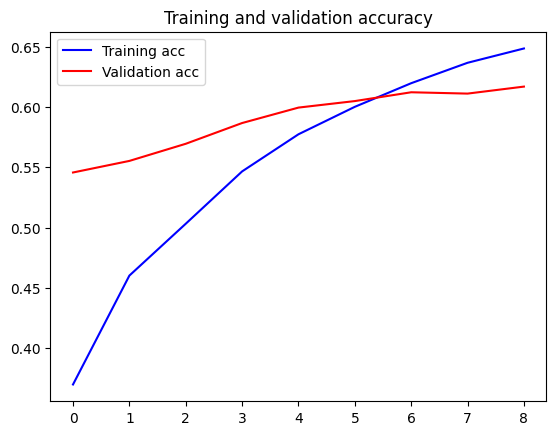

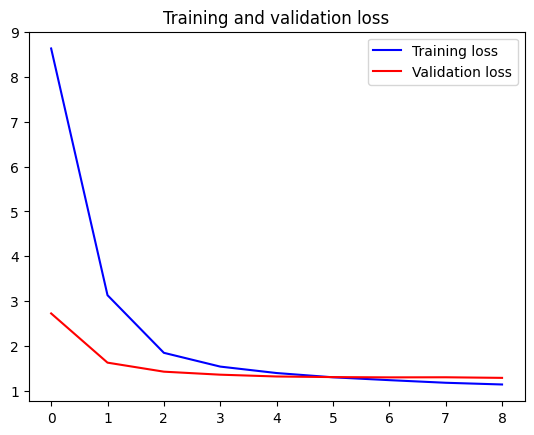

In [10]:
# Plot the accuracy and loss curves
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [11]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from VGG. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(vgg_conv.layers):
   print(i, layer.name)

0 input_layer
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool


In [12]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in vgg_conv.layers[:15]:
   layer.trainable = False
for layer in vgg_conv.layers[15:]:
   layer.trainable = True

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer.name, layer.trainable)

input_layer False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,785,814 (60.22 MB)

 Trainable params: 7,614,986 (29.05 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 535,564 (2.04 MB)

In [15]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9),
              loss='categorical_crossentropy', metrics=['acc'])

In [16]:
history = model.fit(x_train, y_train,
              batch_size=64,
              epochs=3,
              validation_data=(x_test, y_test))

Epoch 1/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - acc: 0.6299 - loss: 1.1252 - val_acc: 0.6632 - val_loss: 1.0241
Epoch 2/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - acc: 0.6950 - loss: 0.8945 - val_acc: 0.6915 - val_loss: 0.9399
Epoch 3/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - acc: 0.7299 - loss: 0.7784 - val_acc: 0.7051 - val_loss: 0.9093


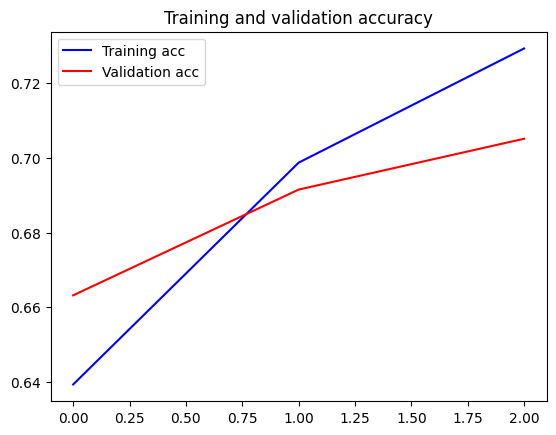

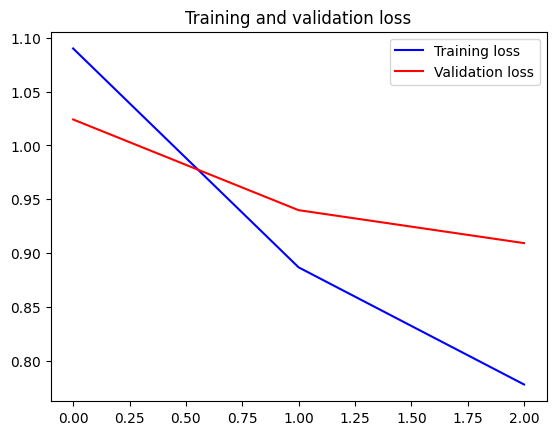

In [17]:
# Plot the accuracy and loss curves
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()